
# Part 2 — Hypothesis Testing, Trend Analysis, and Financial Ratios

This notebook continues the analysis using the same dataset (`financial_health_analysis_dataset.csv`).  
It covers:
- Hypothesis testing (two scenarios)
- P-value interpretation
- Year-over-year (YoY) trend analysis for revenue and profit
- Financial ratios and comparison to benchmarks
- A final Markdown summary section for conclusions and anomalies


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Display options
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Load dataset
df = pd.read_csv('financial_health_analysis_dataset.csv')

# Parse Date
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
else:
    raise ValueError("The dataset must contain a 'Date' column.")

# Basic sanity checks
required_cols = {'Revenue','Expenses','Profit','Cash Flow','Debt','Assets','Liabilities'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Ensure numeric
for c in ['Revenue','Expenses','Profit','Cash Flow','Debt','Assets','Liabilities']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows that are entirely NaN across required fields
df = df.dropna(subset=['Revenue','Expenses','Profit','Cash Flow','Debt','Assets','Liabilities'], how='all')

# Derive helper time columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()



## A. Hypothesis Testing

### Scenario 1: Is the average monthly profit greater than a benchmark?
- **Null (H₀):** μₚ ≤ benchmark  
- **Alt (H₁):** μₚ > benchmark

We'll aggregate profit by month, then apply a one-sample t-test against the benchmark.  


In [2]:

# ---- Parameters ----
PROFIT_BENCHMARK = 10000.0  # change if needed

# Monthly profit (mean by month if multiple rows per month; else it's the monthly value)
monthly_profit = df.groupby('Month', as_index=False)['Profit'].mean().dropna()

# One-sample t-test against benchmark (two-sided), then convert to one-sided
t_stat, p_two_sided = stats.ttest_1samp(monthly_profit['Profit'], popmean=PROFIT_BENCHMARK, nan_policy='omit')

# Convert to one-sided p-value depending on direction of t-stat
if t_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    # if t_stat <= 0, evidence is not in the direction of H1
    p_one_sided = 1.0 - (p_two_sided / 2)

mean_monthly_profit = monthly_profit['Profit'].mean()
n_months = monthly_profit.shape[0]

print(f"Benchmark: {PROFIT_BENCHMARK:,.2f}")
print(f"Mean monthly profit: {mean_monthly_profit:,.2f} (n={n_months})")
print(f"t-statistic: {t_stat:,.4f}")
print(f"One-sided p-value (H1: mean > benchmark): {p_one_sided:,.6f}")
alpha = 0.05
decision = "REJECT H0" if p_one_sided < alpha and t_stat > 0 else "FAIL TO REJECT H0"
print(f"Decision at α={alpha}: {decision}")


Benchmark: 10,000.00
Mean monthly profit: 12,259.17 (n=658)
t-statistic: 10.9337
One-sided p-value (H1: mean > benchmark): 0.000000
Decision at α=0.05: REJECT H0



### Scenario 2: Are average revenue and expenses significantly different?
Because revenue and expenses are recorded for the **same periods**, we use a **paired t-test**.

- **Null (H₀):** μ₍Revenue−Expenses₎ = 0  
- **Alt (H₁):** μ₍Revenue−Expenses₎ ≠ 0  


In [3]:

# Align by month for a clean matched comparison
monthly = df.groupby('Month', as_index=False).agg({'Revenue':'mean','Expenses':'mean'}).dropna()

# Paired t-test (two-sided)
t_stat_rel, p_val_rel = stats.ttest_rel(monthly['Revenue'], monthly['Expenses'], nan_policy='omit')

diff_mean = (monthly['Revenue'] - monthly['Expenses']).mean()

print(f"Mean(Revenue - Expenses): {diff_mean:,.2f}")
print(f"t-statistic (paired): {t_stat_rel:,.4f}")
print(f"Two-sided p-value: {p_val_rel:,.6f}")
alpha = 0.05
decision = "REJECT H0 (significant difference)" if p_val_rel < alpha else "FAIL TO REJECT H0 (no significant difference)"
print(f"Decision at α={alpha}: {decision}")


Mean(Revenue - Expenses): 12,259.17
t-statistic (paired): 59.3305
Two-sided p-value: 0.000000
Decision at α=0.05: REJECT H0 (significant difference)



## B. P-value Interpretation

- The **p-value** represents the probability of observing results at least as extreme as the sample, assuming the **null hypothesis is true**.  
- A **small p-value** (typically < 0.05) indicates the observed effect would be rare if the null were true, leading us to **reject H₀**.  
- A **large p-value** suggests the data are consistent with the null, so we **fail to reject H₀** (not proof that H₀ is true).  



## C. Trend Analysis — Year-over-Year (YoY) for Revenue and Profit
We compute annual totals and their YoY growth rates. We also flag unusually large changes using a z-score on growth rates.


,Year,Revenue,Profit,Revenue_YoY,Profit_YoY
0,2000,21977632,4583807,NaN,NaN
1,2001,21096388,4005856,-0.0401,-0.1261
2,2002,21669485,4640653,0.0272,0.1585
3,2003,21993063,4892870,0.0149,0.0543
4,2004,22102449,4854704,0.0050,-0.0078
5,2005,22305180,4598538,0.0092,-0.0528
6,2006,20821100,3709826,-0.0665,-0.1933
7,2007,22446138,5500939,0.0780,0.4828
8,2008,21847798,4346369,-0.0267,-0.2099
9,2009,21311410,3970276,-0.0246,-0.0865


Significant YoY changes (|z| ≥ 2):
  Revenue_YoY: years [2054]
  Profit_YoY: years [2007, 2017]


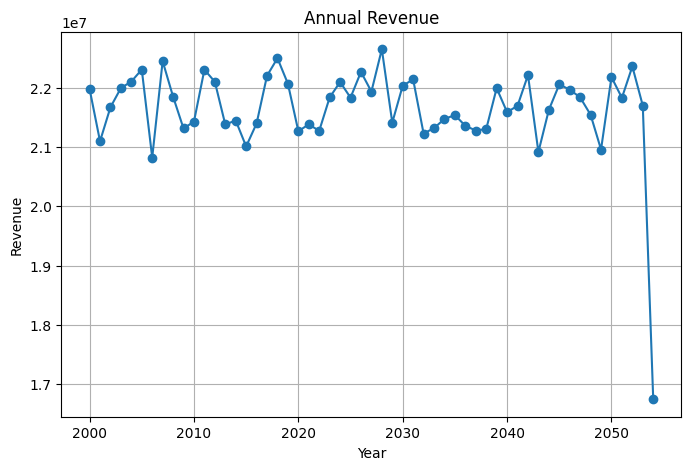

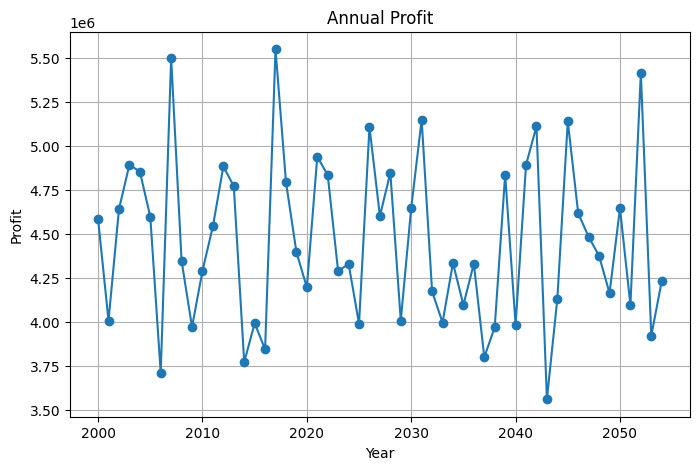

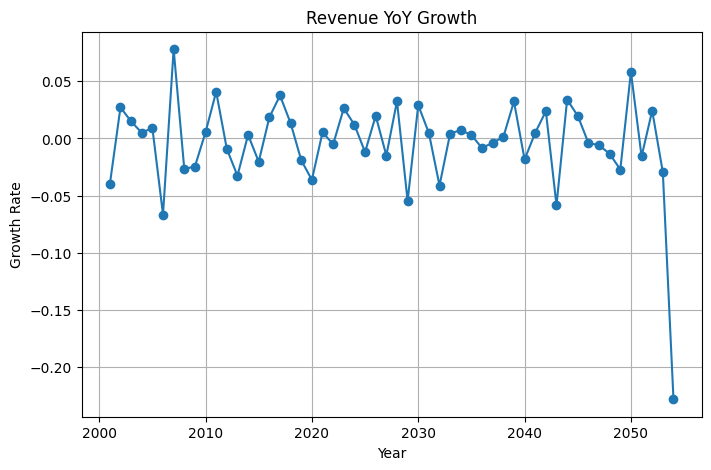

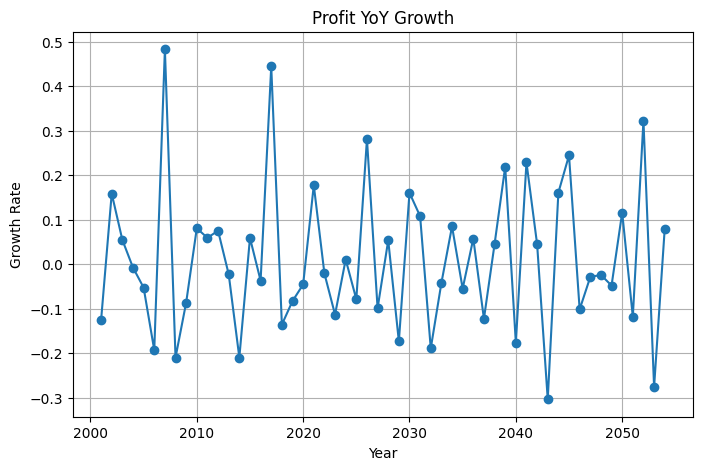

In [4]:

# Annual totals
annual = df.groupby('Year', as_index=False).agg({'Revenue':'sum','Profit':'sum'}).sort_values('Year')

# YoY growth rates
annual['Revenue_YoY'] = annual['Revenue'].pct_change()
annual['Profit_YoY'] = annual['Profit'].pct_change()

display(annual)

# Identify periods of significant change using z-scores of growth (drop NA first)
growth_cols = ['Revenue_YoY','Profit_YoY']
growth = annual.dropna(subset=growth_cols).copy()

for col in growth_cols:
    growth[col + '_z'] = (growth[col] - growth[col].mean()) / growth[col].std(ddof=1)

# Flag changes with |z| >= 2 as "significant" (you can adjust threshold)
significant_flags = {}
for col in growth_cols:
    sig_years = growth.loc[growth[col + '_z'].abs() >= 2, 'Year'].tolist()
    significant_flags[col] = sig_years

print("Significant YoY changes (|z| ≥ 2):")
for k, v in significant_flags.items():
    print(f"  {k}: years {v if v else 'None'}")

# Plot annual Revenue and Profit
plt.figure(figsize=(8,5))
plt.plot(annual['Year'], annual['Revenue'], marker='o')
plt.title('Annual Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(annual['Year'], annual['Profit'], marker='o')
plt.title('Annual Profit')
plt.xlabel('Year')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# Plot YoY growth rates
plt.figure(figsize=(8,5))
plt.plot(annual['Year'], annual['Revenue_YoY'], marker='o')
plt.title('Revenue YoY Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(annual['Year'], annual['Profit_YoY'], marker='o')
plt.title('Profit YoY Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.grid(True)
plt.show()



## D. Financial Ratios and Insights

We compute:
- **Profit Margin** = Profit / Revenue  
- **Debt-to-Asset Ratio** = Debt / Assets  
- **Current Ratio** = Assets / Liabilities  

Then we compare to configurable **industry benchmarks** (you can change these).


,Year,Profit_Margin,Debt_To_Asset,Current_Ratio
count,55.0000,55.0000,55.0000,55.0000
mean,"2,027.0000",0.0387,0.3302,2.5105
std,16.0208,0.0308,0.0096,0.0652
min,"2,000.0000",-0.0168,0.3097,2.3774
25%,"2,013.5000",0.0121,0.3232,2.4563
50%,"2,027.0000",0.0351,0.3303,2.5193
75%,"2,040.5000",0.0648,0.3371,2.5587
max,"2,054.0000",0.1076,0.3515,2.6604


Latest year: 2054
  Profit_Margin: 0.1059 vs benchmark 0.1000 -> MEETS/EXCEEDS
  Debt_To_Asset: 0.3237 vs benchmark 0.5000 -> MEETS/EXCEEDS
  Current_Ratio: 2.5923 vs benchmark 1.5000 -> MEETS/EXCEEDS


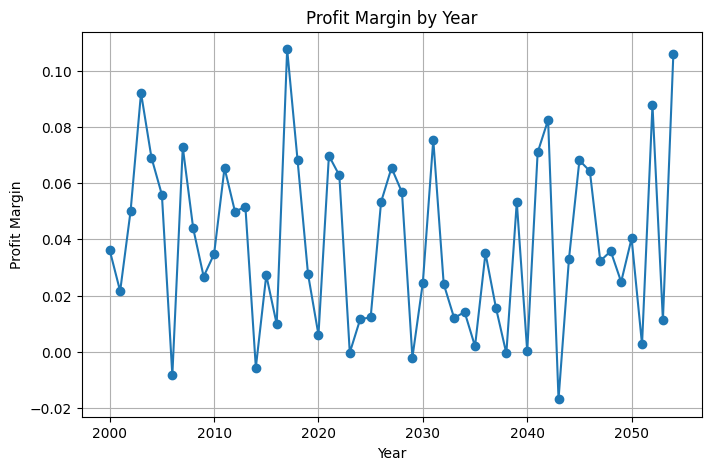

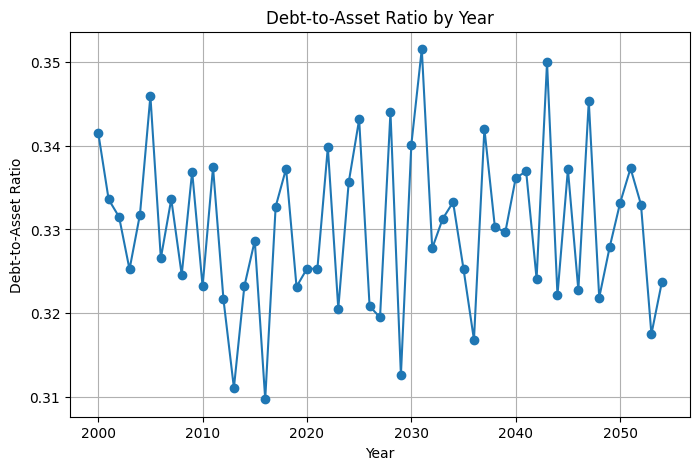

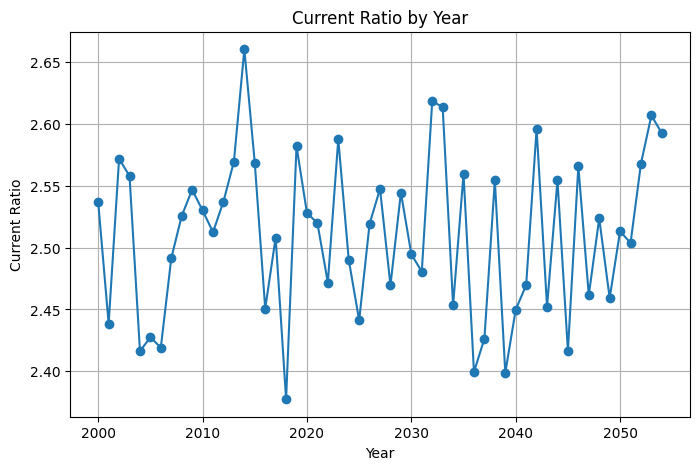

In [5]:

# Compute ratios row-wise
ratios = df.copy()
# Avoid division by zero
ratios['Profit_Margin'] = np.where(ratios['Revenue'] != 0, ratios['Profit'] / ratios['Revenue'], np.nan)
ratios['Debt_To_Asset'] = np.where(ratios['Assets'] != 0, ratios['Debt'] / ratios['Assets'], np.nan)
ratios['Current_Ratio'] = np.where(ratios['Liabilities'] != 0, ratios['Assets'] / ratios['Liabilities'], np.nan)

# Aggregate by year (mean ratios)
ratio_yearly = ratios.groupby('Year', as_index=False)[['Profit_Margin','Debt_To_Asset','Current_Ratio']].mean()

display(ratio_yearly.describe())

# Benchmarks (edit for your industry)
benchmarks = {
    'Profit_Margin': 0.10,   # 10%
    'Debt_To_Asset': 0.50,   # 0.5
    'Current_Ratio': 1.50    # 1.5
}

# Compare latest year averages to benchmarks
latest_year = ratio_yearly['Year'].max()
latest = ratio_yearly.loc[ratio_yearly['Year'] == latest_year, ['Profit_Margin','Debt_To_Asset','Current_Ratio']].squeeze()

print(f"Latest year: {latest_year}")
for k, v in benchmarks.items():
    val = latest[k]
    status = "MEETS/EXCEEDS" if (k != 'Debt_To_Asset' and val >= v) or (k == 'Debt_To_Asset' and val <= v) else "BELOW (or Above for Debt-To-Asset)"
    print(f"  {k}: {val:,.4f} vs benchmark {v:,.4f} -> {status}")

# Visualize ratio trends by year
plt.figure(figsize=(8,5))
plt.plot(ratio_yearly['Year'], ratio_yearly['Profit_Margin'], marker='o')
plt.title('Profit Margin by Year')
plt.xlabel('Year')
plt.ylabel('Profit Margin')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(ratio_yearly['Year'], ratio_yearly['Debt_To_Asset'], marker='o')
plt.title('Debt-to-Asset Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Debt-to-Asset Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(ratio_yearly['Year'], ratio_yearly['Current_Ratio'], marker='o')
plt.title('Current Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Current Ratio')
plt.grid(True)
plt.show()
